## Work
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [8]:
from keras.layers import BatchNormalization, Activation, Dropout
from keras import regularizers

def build_mlp(input_shape, 
              output_units=10, 
              num_neurons=[512, 256, 128],
              use_bn=True,
              drp_ratio=0.,
              l2_ratio=0.):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   kernel_regularizer=regularizers.l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(input_layer)

            if use_bn:
                x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drp_ratio)(x)

        else:
            x = keras.layers.Dense(units=n_units, 
                                   kernel_regularizer=regularizers.l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(x)
            if use_bn:
                x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drp_ratio)(x)
            
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [11]:
## 超參數設定
"""
Set your hyper-parameters
"""
LEARNING_RATE = 1e-3
EPOCHS = 30
BATCH_SIZE = 128

"""
建立實驗組合
"""
USE_BN = [True, False]
DRP_RATIO = [0., 0.4, 0.8]
L2_RATIO = [0., 1e-6, 1e-8]


In [12]:
import keras.backend as K

"""
以迴圈方式遍歷組合來訓練模型
"""
results = {}
for i, (use_bn, drp_ratio, l2_ratio) in enumerate(itertools.product(USE_BN, DRP_RATIO, L2_RATIO)):
    K.clear_session()
    print("Numbers of exp: %i, with bn: %s, drp_ratio: %.2f, l2_ratio: %.2f" % (i, use_bn, drp_ratio, l2_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], use_bn=use_bn, drp_ratio=drp_ratio, l2_ratio=l2_ratio)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              verbose=1,
              shuffle=True)
    
    # Collect results
    exp_name_tag = (f"use_BN: {use_bn}, Dropout ratio: {drp_ratio}, L2 regularization ratio: {l2_ratio}")
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, with bn: True, drp_ratio: 0.00, l2_ratio: 0.00
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
______________________________________________________

Epoch 1/30
391/391 [==============================] - 5s 14ms/step - loss: 1.6167 - accuracy: 0.4237 - val_loss: 1.8011 - val_accuracy: 0.3536
Epoch 2/30
391/391 [==============================] - 5s 13ms/step - loss: 1.3862 - accuracy: 0.5066 - val_loss: 1.9093 - val_accuracy: 0.3362
Epoch 3/30
391/391 [==============================] - 5s 13ms/step - loss: 1.2655 - accuracy: 0.5505 - val_loss: 1.8338 - val_accuracy: 0.3802
Epoch 4/30
391/391 [==============================] - 5s 13ms/step - loss: 1.1728 - accuracy: 0.5851 - val_loss: 1.8064 - val_accuracy: 0.3995
Epoch 5/30
391/391 [==============================] - 5s 13ms/step - loss: 1.0957 - accuracy: 0.6109 - val_loss: 1.7499 - val_accuracy: 0.4138
Epoch 6/30
391/391 [==============================] - 5s 13ms/step - loss: 1.0224 - accuracy: 0.6387 - val_loss: 1.5856 - val_accuracy: 0.4486
Epoch 7/30
391/391 [==============================] - 5s 13ms/step - loss: 0.9502 - accuracy: 0.6653 - val_loss: 1.9018 - val_accuracy: 0.3949

391/391 [==============================] - 5s 14ms/step - loss: 0.6145 - accuracy: 0.7827 - val_loss: 2.2198 - val_accuracy: 0.4056
Epoch 13/30
391/391 [==============================] - 6s 14ms/step - loss: 0.5566 - accuracy: 0.8051 - val_loss: 1.7589 - val_accuracy: 0.4768
Epoch 14/30
391/391 [==============================] - 6s 16ms/step - loss: 0.5060 - accuracy: 0.8221 - val_loss: 2.3592 - val_accuracy: 0.4237
Epoch 15/30
391/391 [==============================] - 5s 14ms/step - loss: 0.4516 - accuracy: 0.8408 - val_loss: 2.2981 - val_accuracy: 0.4304
Epoch 16/30
391/391 [==============================] - 5s 13ms/step - loss: 0.4078 - accuracy: 0.8563 - val_loss: 2.3757 - val_accuracy: 0.4466
Epoch 17/30
391/391 [==============================] - 5s 13ms/step - loss: 0.3667 - accuracy: 0.8726 - val_loss: 2.2953 - val_accuracy: 0.4353
Epoch 18/30
391/391 [==============================] - 5s 13ms/step - loss: 0.3311 - accuracy: 0.8842 - val_loss: 2.4533 - val_accuracy: 0.4651
Epoc

391/391 [==============================] - 4s 10ms/step - loss: 1.1180 - accuracy: 0.6047 - val_loss: 1.4282 - val_accuracy: 0.4951
Epoch 24/30
391/391 [==============================] - 4s 10ms/step - loss: 1.1068 - accuracy: 0.6075 - val_loss: 1.4402 - val_accuracy: 0.4929
Epoch 25/30
391/391 [==============================] - 4s 10ms/step - loss: 1.0942 - accuracy: 0.6115 - val_loss: 1.4105 - val_accuracy: 0.4991
Epoch 26/30
391/391 [==============================] - 4s 10ms/step - loss: 1.0746 - accuracy: 0.6198 - val_loss: 1.4973 - val_accuracy: 0.4777
Epoch 27/30
391/391 [==============================] - 4s 10ms/step - loss: 1.0729 - accuracy: 0.6194 - val_loss: 1.4765 - val_accuracy: 0.4905
Epoch 28/30
391/391 [==============================] - 4s 10ms/step - loss: 1.0601 - accuracy: 0.6273 - val_loss: 1.3752 - val_accuracy: 0.5082
Epoch 29/30
391/391 [==============================] - 4s 10ms/step - loss: 1.0443 - accuracy: 0.6304 - val_loss: 1.4118 - val_accuracy: 0.5055
Epoc

Epoch 1/30
391/391 [==============================] - 6s 15ms/step - loss: 1.9419 - accuracy: 0.3135 - val_loss: 1.8136 - val_accuracy: 0.3481
Epoch 2/30
391/391 [==============================] - 5s 14ms/step - loss: 1.6781 - accuracy: 0.3978 - val_loss: 1.6847 - val_accuracy: 0.3893
Epoch 3/30
391/391 [==============================] - 5s 13ms/step - loss: 1.5865 - accuracy: 0.4311 - val_loss: 1.6574 - val_accuracy: 0.4019
Epoch 4/30
391/391 [==============================] - 5s 13ms/step - loss: 1.5289 - accuracy: 0.4558 - val_loss: 1.6891 - val_accuracy: 0.3874
Epoch 5/30
391/391 [==============================] - 5s 13ms/step - loss: 1.4914 - accuracy: 0.4704 - val_loss: 1.5738 - val_accuracy: 0.4267
Epoch 6/30
391/391 [==============================] - 5s 13ms/step - loss: 1.4476 - accuracy: 0.4833 - val_loss: 1.4850 - val_accuracy: 0.4715
Epoch 7/30
391/391 [==============================] - 5s 13ms/step - loss: 1.4184 - accuracy: 0.4959 - val_loss: 1.5041 - val_accuracy: 0.4645

391/391 [==============================] - 4s 11ms/step - loss: 1.8398 - accuracy: 0.3169 - val_loss: 1.7083 - val_accuracy: 0.3832
Epoch 13/30
391/391 [==============================] - 4s 11ms/step - loss: 1.8241 - accuracy: 0.3261 - val_loss: 1.7042 - val_accuracy: 0.3809
Epoch 14/30
391/391 [==============================] - 4s 11ms/step - loss: 1.8140 - accuracy: 0.3280 - val_loss: 1.6881 - val_accuracy: 0.3837
Epoch 15/30
391/391 [==============================] - 4s 11ms/step - loss: 1.8048 - accuracy: 0.3307 - val_loss: 1.6969 - val_accuracy: 0.3737
Epoch 16/30
391/391 [==============================] - 4s 11ms/step - loss: 1.7962 - accuracy: 0.3334 - val_loss: 1.6782 - val_accuracy: 0.3850
Epoch 17/30
391/391 [==============================] - 4s 11ms/step - loss: 1.7884 - accuracy: 0.3402 - val_loss: 1.6495 - val_accuracy: 0.4061
Epoch 18/30
391/391 [==============================] - 4s 11ms/step - loss: 1.7767 - accuracy: 0.3428 - val_loss: 1.6550 - val_accuracy: 0.3982
Epoc

391/391 [==============================] - 5s 14ms/step - loss: 1.7589 - accuracy: 0.3594 - val_loss: 1.6193 - val_accuracy: 0.4143
Epoch 24/30
391/391 [==============================] - 5s 13ms/step - loss: 1.7536 - accuracy: 0.3614 - val_loss: 1.6501 - val_accuracy: 0.3952
Epoch 25/30
391/391 [==============================] - 5s 14ms/step - loss: 1.7514 - accuracy: 0.3591 - val_loss: 1.6542 - val_accuracy: 0.3856
Epoch 26/30
391/391 [==============================] - 5s 14ms/step - loss: 1.7401 - accuracy: 0.3645 - val_loss: 1.6421 - val_accuracy: 0.3996
Epoch 27/30
391/391 [==============================] - 5s 14ms/step - loss: 1.7345 - accuracy: 0.3680 - val_loss: 1.5999 - val_accuracy: 0.4241
Epoch 28/30
391/391 [==============================] - 5s 14ms/step - loss: 1.7389 - accuracy: 0.3693 - val_loss: 1.6120 - val_accuracy: 0.4219
Epoch 29/30
391/391 [==============================] - 5s 14ms/step - loss: 1.7282 - accuracy: 0.3742 - val_loss: 1.6224 - val_accuracy: 0.4110
Epoc

Epoch 1/30
391/391 [==============================] - 4s 10ms/step - loss: 1.8771 - accuracy: 0.3196 - val_loss: 1.7303 - val_accuracy: 0.3866
Epoch 2/30
391/391 [==============================] - 4s 9ms/step - loss: 1.6844 - accuracy: 0.3923 - val_loss: 1.6434 - val_accuracy: 0.4121
Epoch 3/30
391/391 [==============================] - 4s 9ms/step - loss: 1.5982 - accuracy: 0.4274 - val_loss: 1.5578 - val_accuracy: 0.4454
Epoch 4/30
391/391 [==============================] - 4s 9ms/step - loss: 1.5317 - accuracy: 0.4517 - val_loss: 1.5681 - val_accuracy: 0.4378
Epoch 5/30
391/391 [==============================] - 4s 9ms/step - loss: 1.4921 - accuracy: 0.4671 - val_loss: 1.5119 - val_accuracy: 0.4600
Epoch 6/30
391/391 [==============================] - 4s 9ms/step - loss: 1.4507 - accuracy: 0.4801 - val_loss: 1.4748 - val_accuracy: 0.4745
Epoch 7/30
391/391 [==============================] - 4s 9ms/step - loss: 1.4199 - accuracy: 0.4944 - val_loss: 1.4862 - val_accuracy: 0.4781
Epoch

Epoch 15/30
391/391 [==============================] - 5s 12ms/step - loss: 1.2214 - accuracy: 0.5657 - val_loss: 1.3546 - val_accuracy: 0.5233
Epoch 16/30
391/391 [==============================] - 5s 12ms/step - loss: 1.1964 - accuracy: 0.5729 - val_loss: 1.3934 - val_accuracy: 0.5083
Epoch 17/30
391/391 [==============================] - 5s 12ms/step - loss: 1.1836 - accuracy: 0.5786 - val_loss: 1.3798 - val_accuracy: 0.5196
Epoch 18/30
391/391 [==============================] - 5s 12ms/step - loss: 1.1631 - accuracy: 0.5844 - val_loss: 1.3834 - val_accuracy: 0.5097
Epoch 19/30
391/391 [==============================] - 5s 12ms/step - loss: 1.1479 - accuracy: 0.5915 - val_loss: 1.3874 - val_accuracy: 0.5198
Epoch 20/30
391/391 [==============================] - 5s 12ms/step - loss: 1.1232 - accuracy: 0.5993 - val_loss: 1.3856 - val_accuracy: 0.5185
Epoch 21/30
391/391 [==============================] - 5s 12ms/step - loss: 1.1106 - accuracy: 0.6017 - val_loss: 1.3984 - val_accuracy:

Epoch 29/30
391/391 [==============================] - 5s 12ms/step - loss: 0.9385 - accuracy: 0.6637 - val_loss: 1.4568 - val_accuracy: 0.5223
Epoch 30/30
391/391 [==============================] - 5s 12ms/step - loss: 0.9157 - accuracy: 0.6715 - val_loss: 1.4747 - val_accuracy: 0.5201
Numbers of exp: 12, with bn: False, drp_ratio: 0.40, l2_ratio: 0.00
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
____________________________

Epoch 1/30
391/391 [==============================] - 5s 13ms/step - loss: 2.1505 - accuracy: 0.1863 - val_loss: 1.9648 - val_accuracy: 0.2790
Epoch 2/30
391/391 [==============================] - 5s 12ms/step - loss: 2.0286 - accuracy: 0.2275 - val_loss: 1.9340 - val_accuracy: 0.2946
Epoch 3/30
391/391 [==============================] - 5s 12ms/step - loss: 1.9904 - accuracy: 0.2465 - val_loss: 1.9426 - val_accuracy: 0.2818
Epoch 4/30
391/391 [==============================] - 5s 12ms/step - loss: 1.9608 - accuracy: 0.2629 - val_loss: 1.9016 - val_accuracy: 0.3016
Epoch 5/30
391/391 [==============================] - 5s 12ms/step - loss: 1.9450 - accuracy: 0.2684 - val_loss: 1.9153 - val_accuracy: 0.3061
Epoch 6/30
391/391 [==============================] - 5s 12ms/step - loss: 1.9324 - accuracy: 0.2755 - val_loss: 1.9192 - val_accuracy: 0.2934
Epoch 7/30
391/391 [==============================] - 5s 12ms/step - loss: 1.9273 - accuracy: 0.2762 - val_loss: 1.8905 - val_accuracy: 0.3086

Epoch 15/30
391/391 [==============================] - 5s 12ms/step - loss: 1.9187 - accuracy: 0.2875 - val_loss: 1.8974 - val_accuracy: 0.3052
Epoch 16/30
391/391 [==============================] - 5s 12ms/step - loss: 1.9110 - accuracy: 0.2891 - val_loss: 1.8856 - val_accuracy: 0.3108
Epoch 17/30
391/391 [==============================] - 5s 12ms/step - loss: 1.9110 - accuracy: 0.2903 - val_loss: 1.8820 - val_accuracy: 0.3359
Epoch 18/30
391/391 [==============================] - 5s 12ms/step - loss: 1.9048 - accuracy: 0.2899 - val_loss: 1.8581 - val_accuracy: 0.3383
Epoch 19/30
391/391 [==============================] - 5s 12ms/step - loss: 1.8975 - accuracy: 0.2949 - val_loss: 1.8928 - val_accuracy: 0.3059
Epoch 20/30
391/391 [==============================] - 5s 12ms/step - loss: 1.8981 - accuracy: 0.2940 - val_loss: 1.8607 - val_accuracy: 0.3411
Epoch 21/30
391/391 [==============================] - 5s 12ms/step - loss: 1.8900 - accuracy: 0.3023 - val_loss: 1.8735 - val_accuracy:

391/391 [==============================] - 4s 9ms/step - loss: 2.3027 - accuracy: 0.0985 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 30/30
391/391 [==============================] - 4s 9ms/step - loss: 2.3027 - accuracy: 0.0999 - val_loss: 2.3026 - val_accuracy: 0.1000
Numbers of exp: 16, with bn: False, drp_ratio: 0.80, l2_ratio: 0.00
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
__________________________________________

Epoch 1/30
391/391 [==============================] - 5s 13ms/step - loss: 2.4145 - accuracy: 0.0997 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/30
391/391 [==============================] - 5s 12ms/step - loss: 2.3030 - accuracy: 0.0984 - val_loss: 2.3026 - val_accuracy: 0.0999
Epoch 3/30
391/391 [==============================] - 5s 12ms/step - loss: 2.3029 - accuracy: 0.0997 - val_loss: 2.3026 - val_accuracy: 0.0999
Epoch 4/30
391/391 [==============================] - 5s 12ms/step - loss: 2.3028 - accuracy: 0.0986 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/30
391/391 [==============================] - 5s 12ms/step - loss: 2.3028 - accuracy: 0.0999 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/30
391/391 [==============================] - 5s 12ms/step - loss: 2.3028 - accuracy: 0.0993 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/30
391/391 [==============================] - 5s 12ms/step - loss: 2.3028 - accuracy: 0.0977 - val_loss: 2.3026 - val_accuracy: 0.1000

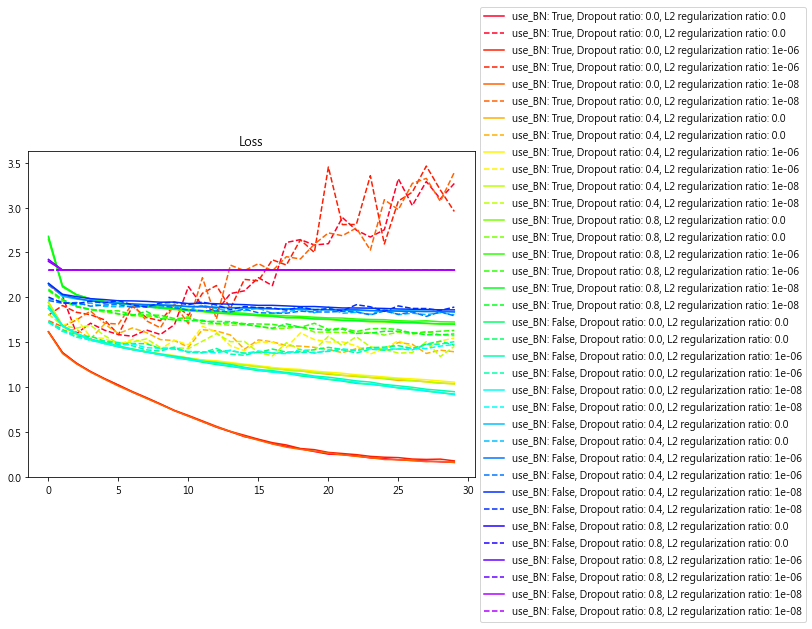

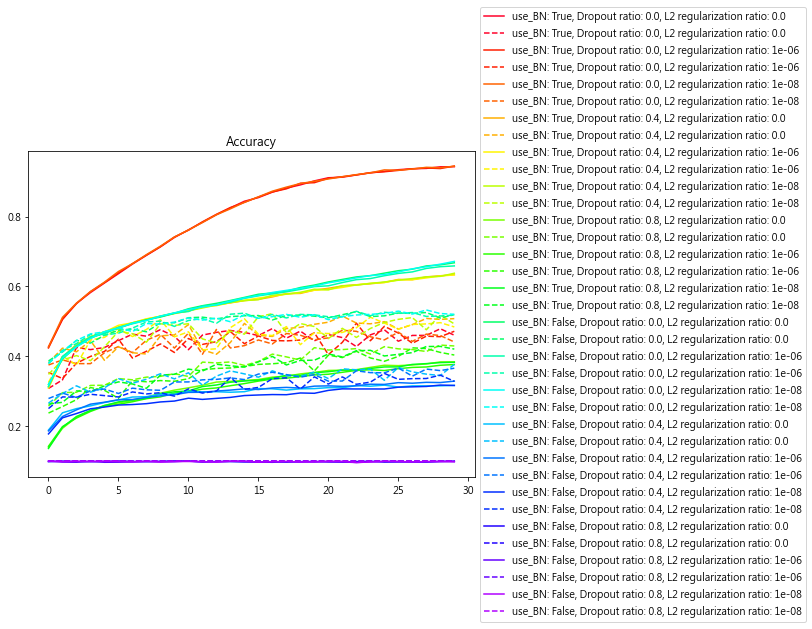

In [13]:
"""
Plot results
"""
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()